# Datos

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lexset/synthetic-asl-alphabet")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/lexset/synthetic-asl-alphabet/versions/3


# Reguladores

Cuando entrenamos redes neuronales, un problema común es el **sobreajuste** (*overfitting*), donde el modelo aprende demasiado bien los datos de entrenamiento pero no generaliza bien a datos nuevos. Para evitarlo, aplicamos **técnicas de regularización**. Estas pueden clasificarse en:

1. **Regularización Explícita:** Métodos que **modifican directamente la función de pérdida** o las actualizaciones de los pesos mediante términos de penalización o técnicas matemáticas definidas.
2. **Regularización Implícita:** Métodos que **no modifican directamente la función de pérdida**, sino que afectan la manera en que se entrena la red para mejorar la generalización.

## **1. Regularización Explícita**
La regularización explícita añade restricciones matemáticas directamente en la optimización de la red. Los métodos más comunes incluyen:

### **1.1 Regularización L1 y L2 (Weight Decay)**
Son las más utilizadas y agregan una penalización a los pesos de la red en la función de pérdida.

#### **Regularización L1 (Lasso Regression)**
Penaliza la **suma de los valores absolutos** de los pesos:

$$
L = L_{\text{original}} + \lambda \sum_j |w_j|
$$

- Promueve **sparsity** (varios pesos se vuelven exactamente cero), lo que ayuda en la selección de características.
- Es útil cuando queremos que algunos parámetros de la red sean ignorados.

#### **Regularización L2 (Ridge Regression o Weight Decay)**
Penaliza la **suma de los cuadrados** de los pesos:

$$
L = L_{\text{original}} + \lambda \sum_j w_j^2
$$

- Hace que los pesos sean más pequeños y menos propensos a valores extremos.
- Reduce la varianza del modelo, evitando que memorice demasiado los datos de entrenamiento.
- Se implementa con el argumento `weight_decay` en PyTorch.

#### **Regularización Elastic Net (L1 + L2)**
Combinación de L1 y L2:

$$
L = L_{\text{original}} + \lambda_1 \sum_j |w_j| + \lambda_2 \sum_j w_j^2
$$

- Se usa cuando queremos sparsity pero también estabilidad en la optimización.
- Común en problemas de regresión o selección de características.

### **1.2 Dropout**
Dropout es una técnica de regularización que **apaga aleatoriamente algunas neuronas durante el entrenamiento**, forzando a la red a no depender demasiado de características específicas.

$$
h_i = \text{Dropout}(x) = x \cdot M, \quad M \sim \text{Bernoulli}(p)
$$

Donde:
- \( p \) es la probabilidad de mantener activa una neurona.
- \( M \) es una máscara de Bernoulli que decide qué neuronas se apagan.

### **1.3 Batch Normalization**
Batch Normalization **normaliza las activaciones de cada capa**, estabilizando el entrenamiento y reduciendo la dependencia de valores extremos.

$$
y_i = \gamma \frac{x_i - \mu_B}{\sigma_B} + \beta
$$

Donde:
- $ \mu_B $ y $ \sigma_B $ son la media y desviación estándar del mini-lote.
- $ \gamma $ y $ \beta $ son parámetros aprendidos.


### **2.1 Early Stopping**
Finaliza el entrenamiento cuando la pérdida en el conjunto de validación deja de mejorar.

### **2.2 Data Augmentation**
Genera datos adicionales mediante transformaciones para evitar que el modelo se sobreajuste.

### **2.3 Noise Injection**
Añadir ruido a los datos o a las activaciones durante el entrenamiento evita que el modelo dependa de pequeñas variaciones.


# Ejemplo (aplicando todo)

In [ ]:
import torch
from torch import nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

class AddGaussianNoise:
    def __init__(self, mean=0., std=0.01):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn_like(tensor) * self.std + self.mean

    def __repr__(self):
        return f"AddGaussianNoise(mean={self.mean}, std={self.std})"



# Definir transformaciones para el conjunto de entrenamiento (con Data Augmentation)
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(p=0.5),  # Volteo horizontal aleatorio
    transforms.RandomRotation(15),  # Rotación aleatoria entre -15° y 15°
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Variaciones de color
    transforms.ToTensor(),
    AddGaussianNoise(std=0.01),  # Añadir ruido gaussiano (Noise injection)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transformaciones para el conjunto de prueba (sin Data Augmentation)
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Rutas de los conjuntos de datos
train_path = "/root/.cache/kagglehub/datasets/lexset/synthetic-asl-alphabet/versions/3/Train_Alphabet"
test_path = "/root/.cache/kagglehub/datasets/lexset/synthetic-asl-alphabet/versions/3/Test_Alphabet"

# Cargar datasets usando ImageFolder (cada carpeta tiene subcarpetas por clase)
train_dataset = datasets.ImageFolder(root=train_path, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=test_transform)

# Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Verificar número de clases
print(f"Número de clases: {len(train_dataset.classes)}")
print(f"Clases disponibles: {train_dataset.classes}")



Número de clases: 27
Clases disponibles: ['A', 'B', 'Blank', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


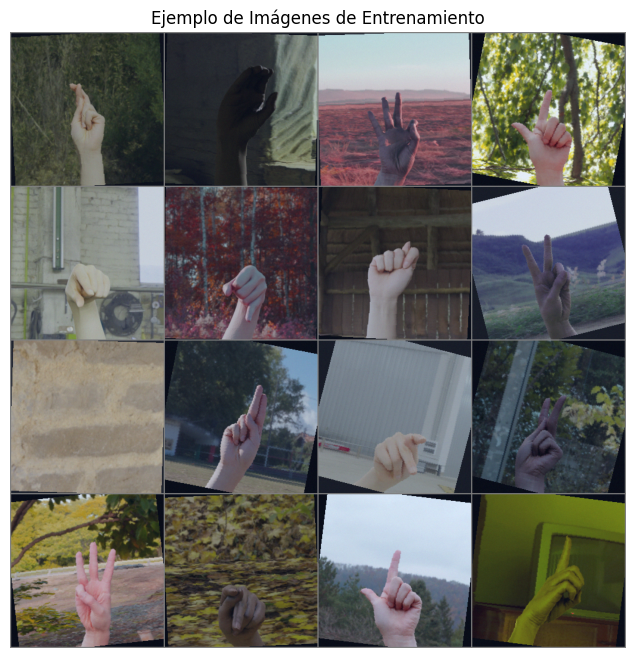

In [ ]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Función para visualizar imágenes del dataset
def show_images(dataloader, num_images=16, title="Muestras del Dataset"):
    """
    Muestra un conjunto de imágenes de un DataLoader en una cuadrícula.

    Parámetros:
        dataloader: DataLoader de PyTorch (train_loader o test_loader).
        num_images: Número de imágenes a mostrar.
        title: Título del gráfico.
    """
    # Obtener un batch de imágenes
    images, labels = next(iter(dataloader))

    # Seleccionar solo num_images imágenes
    images = images[:num_images]

    # Convertir imágenes a rango [0,1] para visualización si están normalizadas
    grid_img = vutils.make_grid(images, nrow=4, normalize=True, pad_value=0.5)

    # Convertir el tensor a numpy para matplotlib
    plt.figure(figsize=(8,8))
    plt.imshow(grid_img.permute(1, 2, 0))  # Cambiar dimensiones de (C, H, W) a (H, W, C)
    plt.axis("off")
    plt.title(title)
    plt.show()

# Llamar a la función con train_loader o test_loader
show_images(train_loader, num_images=16, title="Ejemplo de Imágenes de Entrenamiento")


# Modelo

In [ ]:
class Sign_lang(nn.Module):
    def __init__(self):
        super(Sign_lang, self).__init__()
        self.conv1 = nn.Conv2d(3,8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(8,16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16,32, kernel_size=3, stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(8) #BatchNorm
        self.batchnorm2 = nn.BatchNorm2d(16)
        self.batchnorm3 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32768, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128,27)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.3) #Dropout

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.leaky_relu(x)#224x224x8
        x = self.maxpool(x) #112x112x8
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.leaky_relu(x)
        x = self.maxpool(x)
        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = self.leaky_relu(x)
        x = self.maxpool(x)
        #print("Tamaño antes de Flatten:", x.shape)
        x = x.view(x.size(0), -1)  # Aplanar la salida
        #print("Tamaño después de Flatten:", x.shape)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        return x

In [ ]:
model = Sign_lang()
dummy_input = torch.randn(8, 3, 256, 256)  # Simular batch de 8 imágenes RGB
output = model(dummy_input)

In [ ]:
def train(model, train_loader, test_loader, criterion, optimizer, device, epochs=10):
    """
    Entrena y evalúa el modelo en múltiples épocas.

    Parámetros:
        model: Red neuronal en PyTorch
        train_loader: DataLoader para entrenamiento
        test_loader: DataLoader para evaluación
        criterion: Función de pérdida (CrossEntropyLoss o MSELoss)
        optimizer: Optimizador (Adam, SGD, etc.)
        device: CPU o GPU
        epochs: Número de épocas de entrenamiento
    """
    for epoch in range(epochs):
        #Entrenamiento
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for batch_idx, (image, label) in enumerate(train_loader):
            image, label = image.to(device), label.to(device)

            optimizer.zero_grad()
            output = model(image)

            # Calcular pérdida
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Calcular Accuracy en entrenamiento
            pred = torch.argmax(output, dim=1)  # Convertir output en clases
            correct_train += (pred == label).sum().item()
            total_train += label.size(0)

            # Mostrar progreso cada 100 lotes
            if (batch_idx + 1) % 100 == 0:
                print(f"Época {epoch+1}/{epochs} - Lote {batch_idx+1}/{len(train_loader)} - Pérdida: {loss.item():.4f}")

        train_accuracy = 100. * correct_train / total_train
        avg_train_loss = train_loss / len(train_loader)

        #Evaluación (Test/Validación)
        model.eval()
        test_loss = 0
        correct_test = 0
        total_test = 0

        with torch.no_grad():  # No calcular gradientes en test
            for image, label in test_loader:
                image, label = image.to(device), label.to(device)

                output = model(image)
                loss = criterion(output, label)

                test_loss += loss.item()

                # Calcular Accuracy en test
                pred = torch.argmax(output, dim=1)
                correct_test += (pred == label).sum().item()
                total_test += label.size(0)

        test_accuracy = 100. * correct_test / total_test
        avg_test_loss = test_loss / len(test_loader)

        #Imprimir métricas de la época
        print(f"Época {epoch+1}/{epochs} | Pérdida Train: {avg_train_loss:.4f} | Accuracy Train: {train_accuracy:.2f}%")
        print(f"Pérdida Test: {avg_test_loss:.4f} | Accuracy Test: {test_accuracy:.2f}%\n")

    print("Entrenamiento finalizado.")

## **AdamW y su Diferencia con Adam**

AdamW es una **mejora del optimizador Adam** diseñada para manejar correctamente la **regularización L2 (Weight Decay)**.
Mientras que **Adam** es ampliamente utilizado debido a su capacidad de adaptarse a diferentes problemas, **su implementación del Weight Decay es incorrecta**, lo que puede afectar la regularización y la capacidad de generalización del modelo. **AdamW corrige este problema, mejorando la estabilidad del entrenamiento y reduciendo el sobreajuste**.

# **¿Qué es AdamW?**
AdamW es una variante de **Adam** que maneja correctamente la **regularización L2 (weight decay)** al separar la **actualización de los pesos** del **cálculo del gradiente**.
El weight decay se usa comúnmente para **prevenir el sobreajuste** al penalizar los pesos grandes. En optimizadores como SGD, se implementa correctamente restando un pequeño porcentaje del valor de los pesos en cada actualización. Sin embargo, en Adam, el weight decay se aplicaba **dentro del cálculo del gradiente**, lo que es incorrecto y afecta la actualización de los pesos.

# **Diferencias**
## **Adam (Weight Decay Incorrecto)**
Adam usa la siguiente ecuación para actualizar los pesos $ \theta $:

1. **Cálculo de los Momentos de Primer y Segundo Orden**:
  $$
   m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t
 $$
  $$
   v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2
  $$

2. **Corrección de Sesgo**:
   $$
   \hat{m_t} = \frac{m_t}{1 - \beta_1^t}, \quad \hat{v_t} = \frac{v_t}{1 - \beta_2^t}
 $$

3. **Actualización de los Pesos con Weight Decay Dentro del Gradiente**:
  $$
   \theta_{t+1} = \theta_t - \eta \left( \frac{\hat{m_t}}{\sqrt{\hat{v_t}} + \epsilon} + \lambda \theta_t \right)
   $$
   **Problema:**  
   - El weight decay $ \lambda \theta_t $ se incluye dentro del gradiente, lo que **altera el cálculo del gradiente y afecta la optimización**.  
   - Esto **mezcla la optimización y la regularización**, causando que el modelo no se regularice correctamente.

## **AdamW (Weight Decay Correcto)**
AdamW separa el weight decay de la actualización del gradiente:

1. **Cálculo del Gradiente (sin Weight Decay)**:
   $$
   m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t
   $$
   $$
   v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2
   $$

2. **Corrección de Sesgo**:
   $$
   \hat{m_t} = \frac{m_t}{1 - \beta_1^t}, \quad \hat{v_t} = \frac{v_t}{1 - \beta_2^t}
   $$

3. **Actualización de los Pesos con Weight Decay Separado**:
   $$
   \theta_{t+1} = \theta_t - \eta \frac{\hat{m_t}}{\sqrt{\hat{v_t}} + \epsilon} - \eta \lambda \theta_t
   $$

**Corrección en AdamW**:  
- **El weight decay se aplica después de la actualización del gradiente**.  
- **No interfiere con la optimización**, lo que mejora la generalización del modelo.  
- Se comporta más parecido a **SGD con L2 regularization**, que es la forma correcta de aplicar el weight decay.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Sign_lang().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0003, weight_decay=0.01)

In [ ]:
train(model, train_loader, test_loader, criterion, optimizer, device, epochs=10)

Época 1/10 - Lote 100/760 - Pérdida: 3.3768
Época 1/10 - Lote 200/760 - Pérdida: 3.2760
Época 1/10 - Lote 300/760 - Pérdida: 3.2971
Época 1/10 - Lote 400/760 - Pérdida: 3.2910
Época 1/10 - Lote 500/760 - Pérdida: 3.2903
Época 1/10 - Lote 600/760 - Pérdida: 3.1815
Época 1/10 - Lote 700/760 - Pérdida: 2.8432
Época 1/10 | Pérdida Train: 3.2179 | Accuracy Train: 5.32%
Pérdida Test: 2.6305 | Accuracy Test: 16.74%

Época 2/10 - Lote 100/760 - Pérdida: 2.7068
Época 2/10 - Lote 200/760 - Pérdida: 2.7332
Época 2/10 - Lote 300/760 - Pérdida: 2.4652
Época 2/10 - Lote 400/760 - Pérdida: 2.4778
Época 2/10 - Lote 500/760 - Pérdida: 2.5466
Época 2/10 - Lote 600/760 - Pérdida: 2.3239
Época 2/10 - Lote 700/760 - Pérdida: 2.2994
Época 2/10 | Pérdida Train: 2.5025 | Accuracy Train: 17.91%
Pérdida Test: 1.7855 | Accuracy Test: 43.00%

Época 3/10 - Lote 100/760 - Pérdida: 1.8635


In [ ]:
#Conjunto de imagenes no vistas
path2 = kagglehub.dataset_download("kevarce/lenguaje-de-seas-de-el-salvador-lessa")

print("Path to dataset files:", path2)